# text2poem
Given a list of topics, generate a related poem

## To-do:
- [ ] Tune the batch size
- [ ] Tune the number of epochs

## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 7.1MB/s 
     |████████████████████████████████| 3.3MB 39.0MB/s 
     |████████████████████████████████| 901kB 48.2MB/s 
     |████████████████████████████████| 1.1MB 7.5MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [3]:
%reset -f

## Import Libraries

In [4]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [6]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics_200_top_authors.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

PREFIX = "poemify: " # The T5 prefix to append to the inputs

In [7]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [8]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [9]:
def replaceSep(text, sep = " | "):
    """ Replaces '\n' by sep everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    return text.replace("\n", sep)

In [10]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [11]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [12]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

## Train and Validate Functions:

In [13]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [14]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [15]:
def generate(topics):

    input = PREFIX + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [16]:
def genSample(topics, min_length, max_length, rep_penalty, temp = 1):

    input = PREFIX + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        temperature = temp,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

## Main

In [18]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [19]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

487 482 5


In [20]:
display(df)

,output,input
0,"I have no wit, no words, no tears; | My heart ...","poemify: frozen thing, shall-the sap, royal cu..."
1,"A Bird, came down the Walk - | He did not know...","poemify: softer Home, frightened Beads, rapid ..."
2,My heart is like a singing bird | Whose nest i...,"poemify: rainbow shell, singing bird, silver f..."
3,"You did not come, | And marching Time drew on,...","poemify: little hour, high compassion, pure lo..."
4,"Out of a fired ship, which by no way | But dro...","poemify: burnt ship, fired ship, shot decay, f..."
...,...,...
484,"Sweet and low, sweet and low, | Wind of the we...","poemify: rolling waters, western sea, silver m..."
485,"Tears, idle tears, I know not what they mean, ...","poemify: glimmering square, divine despair, id..."
486,The splendour falls on castle walls | And snow...,"poemify: cataract leaps, wild cataract, rich s..."
487,"Thy voice is heard thro' rolling drums, | That...","poemify: thy knee, face, blow, dead, fancy, ha..."


In [21]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

241 3


### Loading the Model

In [22]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [23]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [24]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [25]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 1


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10


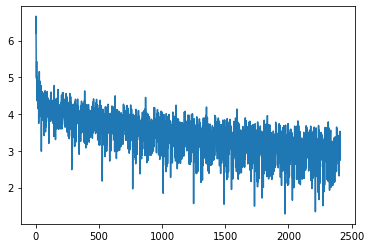

In [26]:
plt.plot(range(len(losses)), losses)
plt.show()

In [27]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [28]:
display(results)

,Generated Text,Actual Text
0,"I am boundless and blotted, | And there is no ...","Sunset and evening star, | And one clear call ..."
1,"Young Stephen, who has sat down with meases an...","And did young Stephen sicken, | And did young ..."
2,"I know that thou despise, | And do not fall in...",Ethereal minstrel! pilgrim of the sky! | Dost ...
3,"I have a dream of perfect rest, | And the char...",Where sunless rivers weep | Their waves into t...
4,"I have a sweet evening yellow, | And the mean ...","Up! up! my Friend, and quit your books; | Or s..."


In [42]:
x = 4
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

I have a sweet evening yellow, | And the mean preacher of this kind sings: "I am not ready wealth to be made up from my mind." 

Up! up! my Friend, and quit your books; | Or surely you'll grow double: | Up! up! my Friend, and clear your looks; | Why all this toil and trouble? | | The sun above the mountain's head, | A freshening lustre mellow | Through all the long green fields has spread, | His first sweet evening yellow. | | Books! 'tis a dull and endless strife: | Come, hear the woodland linnet, | How sweet his music! on my life, | There's more of wisdom in it. | | And hark! how blithe the throstle sings! | He, too, is no mean preacher: | Come forth into the light of things, | Let Nature be your teacher. | | She has a world of ready wealth, | Our minds and hearts to bless- | Spontaneous wisdom breathed by health, | Truth breathed by cheerfulness. | | One impulse from a vernal wood | May teach you more of man, | Of moral evil and of good, | Than all the sages can. | | Sweet is the lo

In [30]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.3, 0.9)

I think it is because the wind does not want to go.
It is a forest where the tree lies,
And the weeping sun will blow;
The wind will be desolate (see now).
No more shall they come?
So when the wood has gone down this road?
I am still standing there waiting until the snow falls.
In the forest while you wake up,
You should expect that the trees do decay.
How long your leaves are wet and thin from the ground,
If the forest were weaning them in front of me might take away!


In [31]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4, 0.7)

I read the poem, and listened to it:
And then there was one in the forest;
But when we were not standing out of sight,
We did have another.

The wind stopped by me as long ago.
By this I thought that I would come back home.
Now on for now I know how you will grow up again!
I am very proud of my story but what you may be doing is let us live with your heart.
It's gone away from me.


In [39]:
gen = genSample(["happy", "elated smile", "good luck", "beautiful eyes"], 100, 500, 1.3, 0.9)

I think there is an elated smile among the eyes.
Now with some good luck my face will be bright,
And let him know what might be like that!
And now, when he comes to his hand you are happy and smiled at me.
When my friend's eyes look on us, we may have looked through it all:
With this as the happy and smiling eyes of God, they hope not to fear their beautiful eyes;
It has brought up one more stroke than any other in all.


In [33]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.5, 0.9)

An elated smile of happy faces.
I love the glowing sun and moon,
A man who loves to sing is born in his name;
It kissts her smiling faces with joyous eyes:
And she laughs at every moment while walking trees;
She stared upon her dancing trees where they saw them all around me!
Her voice has heard its heart when she stands alone.
Oh well that seemed clear again as long ago-with laughter from my feet....we know not what you would tell how good it were for you?
There have been many other beautiful treasure there was no last but flowers blooming out are like an ear or light and glow contains one image within him standing beside him.


In [34]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.4)

I think so.
I gaze at the glowing sun,
With elated smile on my hands:
You are sitting in amazement to see!
My smiling faces lie and sound like laughter when they look back;
And I seem all that seemed funny as his face unfolds.
On dancing trees we can hear the glow of your feet:
A sight who seems to be joyous is still waiting for you too.
What do there appear upon me was no more than one?
That by myself has grown up with an image set him among happy faces but the night
Looking at the dancing trees...


In [41]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.4, 0.8)

What is the hoary sky?
Is it sitting down in the back of my feet,
To myself taking a picture silly and dangerous.

I am tired by having animales with them as they do not come away!
Oh, what are you doing to raise your legs around me?
Do you feel that since long time ago you have gone up against me or take his boots off old?
Do you think so soon after you let me stop under constant light?
And make sure I would leave those two days now when we were young then; but who cannot bear:
He stands up for himself on the backside?


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```